<a href="https://colab.research.google.com/github/tanoManzo/mimic_trajectories/blob/dev/MIMIC_TRAJECTORY_clustering_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install transformers -q

In [2]:
import torch 
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification

In [3]:
import numpy as np
import pandas as pd

In [4]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/NIH/Data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


load file

In [ ]:
notes_name = 'NOTES_NURSING_TRAJECTORIES_sentimentchange_multipleCG_patient_data.csv'
df_notes = pd.read_csv(file_path+notes_name)
df_notes.info()

pre-processing

In [ ]:
cgid = 17400
df_cg = df_notes[df_notes['CGID']==cgid].drop(['MARITAL_STATUS','EDREGTIME','EDOUTTIME','HAS_CHARTEVENTS_DATA','DEATHTIME'],axis=1)
df_cg.info()

In [ ]:
df_cg

In [8]:
notes_name = "NOTES_NURSING_TRAJECTORIES_01.csv"
df_notes_neonat = pd.read_csv(file_path+notes_name)

In [ ]:
model_ckpt = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
def create_embeddings(list_of_sentences):  
  encoded_input = tokenizer(list_of_sentences, padding=True, truncation=True, return_tensors="pt")
  with torch.no_grad():
    model_output = model(**encoded_input)
  token_embeddings = model_output.last_hidden_state  

  def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

  # Perform pooling
  sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

  # Normalize embeddings
  sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

  sentence_embeddings_np = sentence_embeddings.detach().numpy()

  return sentence_embeddings_np

In [14]:
import json


In [10]:
sub_dic = {}
subid = 7337
df_cg['notes_embeddings']=None
for subid in df_cg['SUBJECT_ID']:
  condition = (df_notes_neonat['CGID'] == cgid) & (df_notes_neonat['SUBJECT_ID'] == subid)
  sentences = df_notes_neonat[condition].sort_values(by='CHARTDATE')['TEXT'].tolist()
  sub_dic[subid] = sentences

In [42]:
data = []
data.extend([create_embeddings(item) for item in sub_dic.values()])

In [ ]:
data

In [12]:
all_embs_data = []
for item in data: 
  for sub_item in item:
    all_embs_data.append(sub_item)

In [13]:
def get_embeddings():
  pass

embeddings = np.array(all_embs_data)
embeddings.shape

(88, 384)

In [45]:
def get_sentiment():  
  clrs = []
  sent = []
  dat = []
  for k, v in sub_dic.items():
    sub_row = df_cg[df_cg['SUBJECT_ID']==k]
    l = json.loads(df_cg[df_cg['SUBJECT_ID']==k]['attitudes_char'].iloc[0])
    for idx,_ in enumerate(v):
      clrs.append(k)
      dat.append(('ETHNICITY:'+sub_row['ETHNICITY'].values[0],'INSURANCE:'+sub_row['INSURANCE'].values[0], 'INSURANCE:'+sub_row['INSURANCE'].values[0], 'note:'+str(idx+1)+'/'+str(len(v))))
    for s in l: 
      sent.append(s)
  return clrs, sent, dat

colors, sentiment, features = get_sentiment()  

In [17]:
sent_dic = {-1:70, 0:10, 1:70}

In [18]:
sent_dic_lab = {-1:'neg', 0:'neu', 1:'pos'}

In [46]:
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.decomposition import PCA

# vars:
# embeddings needs loop
# sentiment needs loop
# features needs loop
# colors needs loop
def plot_data(emb, sent, feats, clrs):

  id_dic = {item:idx for idx,item in enumerate(set(clrs))}

  reduced_data = PCA(n_components=2).fit_transform(emb)
  tsne = TSNE(n_components=2, random_state=0)
  projections = tsne.fit_transform(reduced_data)

  fig = px.scatter(
      projections, x=0,y =1,
      size=[sent_dic[item] for item in sent],
      color=[id_dic[item] for item in clrs],
      hover_name=["subject "+str(id_dic[item]) for item in clrs],
      hover_data=[feats,],
      symbol = [sent_dic_lab[item] for item in sent], labels={'color':'subject_id', 'symbol': 'sentiment'}
  )

  fig.update_layout(legend=dict(
      yanchor="top",
      y=0.99,
      xanchor="left",
      x=0.01
  ))

  fig.show()

plot_data(embeddings, sentiment, features, colors)

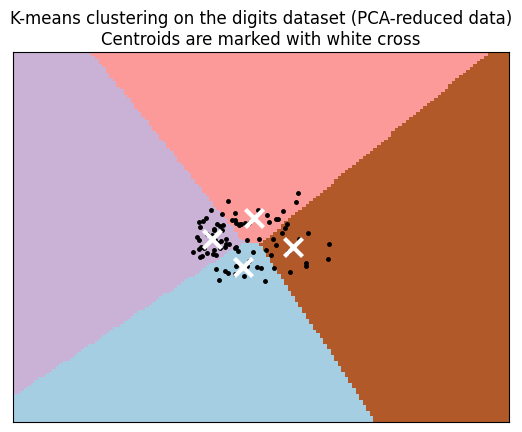

In [21]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


kmeans = KMeans(init="k-means++", n_clusters=4, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()].astype('float32'))

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=5)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()